In [1]:
!pip install langchain langchain-google-genai langchain_community sentence-transformers chromadb umap-learn matplotlib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 974.6/974.6 kB 7.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 15.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 227.1/227.1 kB 25.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 526.8/526.8 kB 18.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.7/85.7 kB 10.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 315.6/315.6 kB 20.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 125.2/125.2 kB 14.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 29.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.0/92.0 kB 10.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.4/62.4 kB 6.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.3/41.3 kB 5.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 49.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━

In [2]:
from google.colab import userdata
import os

os.environ.clear()

if os.environ.get("GOOGLE_API_KEY") is None:
  os.environ["GOOGLE_API_KEY"] = userdata.get("GOOGLE_API_KEY")

os.environ['LANGCHAIN_TRACING_V2'] = "true"
os.environ['LANGCHAIN_ENDPOINT'] = "https://api.smith.langchain.com"
os.environ['LANGCHAIN_API_KEY'] = userdata.get("LANGCHAIN_API_KEY")
os.environ['LANGCHAIN_PROJECT'] = "test-for-kai-v2"

#Seeding the in-memory Vector STORE

###Lost in the middle (LLM) with long texts

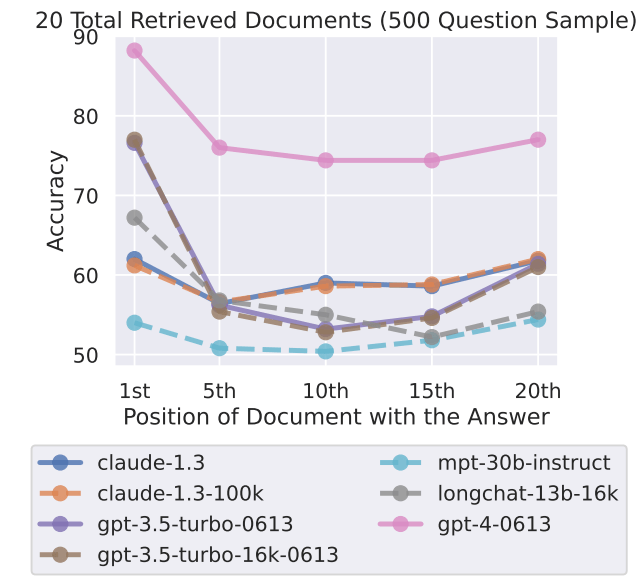

In [3]:
from langchain_community.document_loaders import DirectoryLoader, TextLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_google_genai import GoogleGenerativeAIEmbeddings
from langchain.vectorstores import Chroma

loader = DirectoryLoader('.',glob= '**/*.txt', loader_cls=TextLoader, show_progress=True)
documents = loader.load()
print("\nLoaded documents: ",len(documents))

100%|██████████| 2/2 [00:00<00:00, 911.51it/s]


Loaded documents:  2


In [4]:
text_splitter = RecursiveCharacterTextSplitter(chunk_size=250, chunk_overlap=0, length_function=len)
split_docs = text_splitter.split_documents(documents)
doc_strings = [doc.page_content for doc in split_docs]
print("\nSplit documents: ",len(split_docs))


Split documents:  79


In [5]:
embeddings = GoogleGenerativeAIEmbeddings(model="models/embedding-001")
vectors = embeddings.embed_documents(doc_strings)

In [ ]:
vectors

In [6]:
db = Chroma.from_documents(split_docs, embeddings)
retriever = db.as_retriever(search_kwargs={"k": 6})

#UMAP for Visualizations

We will lose a lot of information due to reducing the dimensionality of the vectors from the bi encoders shape into 2 dimensional for visualization

In [7]:
import umap
import numpy as np
from tqdm import tqdm

In [8]:
umap_transformer = umap.UMAP(random_state=42,transform_seed=0).fit(vectors)

def umap_embed(vectors, umap_transformer):
  umap_embeddings = np.array([umap_transformer.transform([vector])[0] for vector in tqdm(vectors)])
  return umap_embeddings

/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


In [9]:
global_embeddings = umap_embed(vectors, umap_transformer)

100%|██████████| 79/79 [01:31<00:00,  1.16s/it]


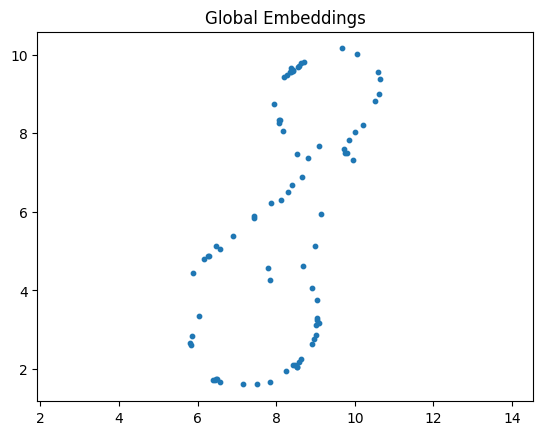

In [10]:
import matplotlib.pyplot as plt

plt.figure()
plt.scatter(global_embeddings[:, 0], global_embeddings[:, 1], s=10)
plt.gca().set_aspect('equal', 'datalim')
plt.title('Global Embeddings')
plt.show()

In [11]:
def calc_global_embeddings(query, embeddings, retriever, umap_transformer, embed_function, global_embeddings):
  q_embedding = embeddings.embed_query(query)

  docs = retriever.get_relevant_documents(query)
  page_contents = [doc.page_content for doc in docs]
  vectors_content_vectors = embeddings.embed_documents(page_contents)

  query_embeddings = embed_function([q_embedding], umap_transformer)
  retrieved_embeddings = embed_function(vectors_content_vectors, umap_transformer)

  plt.figure()
  plt.scatter(global_embeddings[:, 0], global_embeddings[:, 1], s=10, color='gray')
  plt.scatter(query_embeddings[:, 0], query_embeddings[:, 1], s=150, marker='x', color='r')
  plt.scatter(retrieved_embeddings[:, 0], retrieved_embeddings[:, 1], s=50, facecolors='none', edgecolors='g')
  plt.gca().set_aspect('equal', 'datalim')
  plt.title(f'{query}')
  plt.axis('off')
  plt.show()

100%|██████████| 6/6 [00:14<00:00,  2.44s/it]


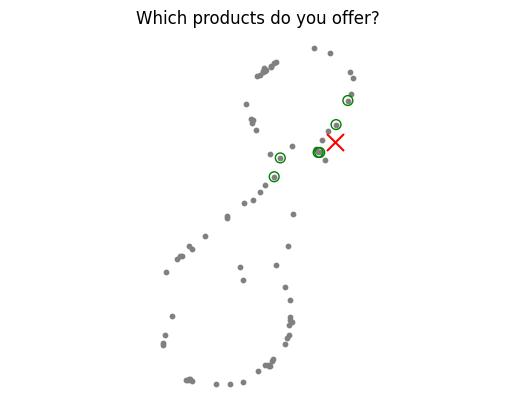

In [16]:
calc_global_embeddings("Which products do you offer?", embeddings, retriever, umap_transformer, umap_embed, global_embeddings)

100%|██████████| 6/6 [00:06<00:00,  1.02s/it]


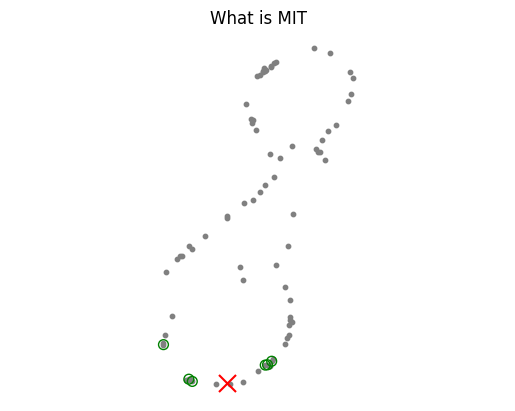

In [17]:
calc_global_embeddings("What is MIT", embeddings, retriever, umap_transformer, umap_embed, global_embeddings)

#Query Expansion

We can use an LLM to exapn the query into multiple rephrases, so that we can refine the documents related to our query at a higher accuracy

In [18]:
from langchain_google_genai import GoogleGenerativeAI

llm = GoogleGenerativeAI(model="gemini-1.0-pro", temperature=0)

In [19]:
from langchain.output_parsers import PydanticOutputParser
from langchain.prompts import PromptTemplate
from pydantic import BaseModel, Field

query = "What is MIT?"

class LineList(BaseModel):
  lines: list[str] = Field(description="Lines of text")

class LineListOutputParser(PydanticOutputParser):
  def __init__(self) -> None:
    super().__init__(pydantic_object = LineList)

    def parse(self, text: str) -> list[str]:
      lines = text.strip().split("\n")
      return lines

output_parser = LineListOutputParser()

QUERY_PROMPT = PromptTemplate(
    template = """You are an AI language model assistant
    Your task is to generate five different versions of the given user question to retrieve relevant documents from a vector database.
    By generating multiple perspectives on the user question, your goal is to help the user overcome some of the limitations of the distance in the search similarity process.
    Provide those alternative questions separated by newlines. Only provide the query, no numbering

    {format_instructions}

    Original question:
    {question}
    """,
    input_variable=['question'],
    partial_variables={"format_instructions": output_parser.get_format_instructions()}
)

QUERY_PROMPT.invoke(query)

llm_chain = QUERY_PROMPT | llm | output_parser
queries = llm_chain.invoke(query)

In [20]:
queries

LineList(lines=['What is the Massachusetts Institute of Technology?', 'What is the history of MIT?', 'What are the research areas at MIT?', 'What are the notable alumni of MIT?', 'What is the impact of MIT on the world?'])

In [21]:
print(f"Original: {query}")
for line in queries.lines:
  print(f"Query: {line}")

Original: What is MIT?
Query: What is the Massachusetts Institute of Technology?
Query: What is the history of MIT?
Query: What are the research areas at MIT?
Query: What are the notable alumni of MIT?
Query: What is the impact of MIT on the world?


In [22]:
docs = [retriever.get_relevant_documents(query) for query in queries.lines]

In [23]:
docs

[[Document(page_content='The Massachusetts Institute of Technology (MIT) is a private land-grant research university in Cambridge, Massachusetts. Established in 1861, MIT has played a significant role in the development of many areas of modern technology and science.', metadata={'source': 'mit.txt'}),
  Document(page_content='Founded in response to the increasing industrialization of the United States, MIT adopted a European polytechnic university model and stressed laboratory instruction in applied science and engineering. MIT is one of three private land-grant', metadata={'source': 'mit.txt'}),
  Document(page_content='MIT was informally called "Boston Tech".[32] The institute adopted the European polytechnic university model and emphasized laboratory instruction from an early date.[27] Despite chronic financial problems, the institute saw growth in the last two', metadata={'source': 'mit.txt'}),
  Document(page_content='entrepreneurial culture and MIT alumni have founded or co-found

In [24]:
unique_contents = set()
unique_docs = []

for sublist in docs:
  for doc in sublist:
    if doc.page_content not in unique_contents:
      unique_contents.add(doc.page_content)
      unique_docs.append(doc)
unique_contents = list(unique_contents)

unique_contents

['Technology and Innovation recipients, 50 MacArthur Fellows,[12] 83 Marshall Scholars,[13] 41 astronauts,[14] 16 Chief Scientists of the US Air Force, and 1 foreign head of state have been affiliated with MIT. The institute also has a strong',
 'over the vehement objections of MIT faculty, students, and alumni.[38] However, a 1917 decision by the Massachusetts Supreme Judicial Court effectively put an end to the merger scheme.[38]',
 'As of October 2023, 101 Nobel laureates,[10] 26 Turing Award winners, and 8 Fields Medalists have been affiliated with MIT as alumni, faculty members, or researchers.[11] In addition, 58 National Medal of Science recipients, 29 National Medals of',
 'The Massachusetts Institute of Technology (MIT) is a private land-grant research university in Cambridge, Massachusetts. Established in 1861, MIT has played a significant role in the development of many areas of modern technology and science.',
 'entrepreneurial culture and MIT alumni have founded or co-foun

#Cross-encoder Re-ranking
Compared to the original retriever with search kwwargs of 6, we have 17 unique documents retrieved from the rephrasing of the original original query.


We can now try bringing in a specialized model, the cross-encoder, for retrieval. Originally, we will only send 5 documents to the LLM due to limited context window based on similarity search.


Now, let's try a cross encoder for reraknking via checking the similarity from query + document. It is slow and specialized, so keep it as the second step.

In [25]:
from sentence_transformers import CrossEncoder

cross_encoder = CrossEncoder("cross-encoder/ms-marco-MiniLM-L-6-v2")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/794 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

In [26]:
pairs = []
for doc in unique_contents:
  pairs.append([query, doc])

scores = cross_encoder.predict(pairs)
scores

array([-2.0516093 , -3.7694223 , -3.5326986 ,  9.033287  ,  4.212866  ,
       -0.6613178 ,  3.795036  , -1.2558379 , -3.407912  , -0.89255136,
        7.521672  ], dtype=float32)

In [27]:
scored_docs = zip(scores, unique_contents)
sorted_docs = sorted(scored_docs, reverse=True)
sorted_docs

[(9.033287,
  'The Massachusetts Institute of Technology (MIT) is a private land-grant research university in Cambridge, Massachusetts. Established in 1861, MIT has played a significant role in the development of many areas of modern technology and science.'),
 (7.521672,
  'Founded in response to the increasing industrialization of the United States, MIT adopted a European polytechnic university model and stressed laboratory instruction in applied science and engineering. MIT is one of three private land-grant'),
 (4.212866,
  'entrepreneurial culture and MIT alumni have founded or co-founded many notable companies.[15][16] MIT is a member of the Association of American Universities.[17]'),
 (3.795036,
  'MIT was informally called "Boston Tech".[32] The institute adopted the European polytechnic university model and emphasized laboratory instruction from an early date.[27] Despite chronic financial problems, the institute saw growth in the last two'),
 (-0.6613178,
  'The Compton refo

In [29]:
reranked_docs = [doc for _, doc in sorted_docs][0:5]
reranked_docs

['The Massachusetts Institute of Technology (MIT) is a private land-grant research university in Cambridge, Massachusetts. Established in 1861, MIT has played a significant role in the development of many areas of modern technology and science.',
 'Founded in response to the increasing industrialization of the United States, MIT adopted a European polytechnic university model and stressed laboratory instruction in applied science and engineering. MIT is one of three private land-grant',
 'entrepreneurial culture and MIT alumni have founded or co-founded many notable companies.[15][16] MIT is a member of the Association of American Universities.[17]',
 'MIT was informally called "Boston Tech".[32] The institute adopted the European polytechnic university model and emphasized laboratory instruction from an early date.[27] Despite chronic financial problems, the institute saw growth in the last two',
 'The Compton reforms "renewed confidence in the ability of the Institute to develop lead

#Loss in the Middle

[Scientific Paper](https://arxiv.org/abs/2307.03172)

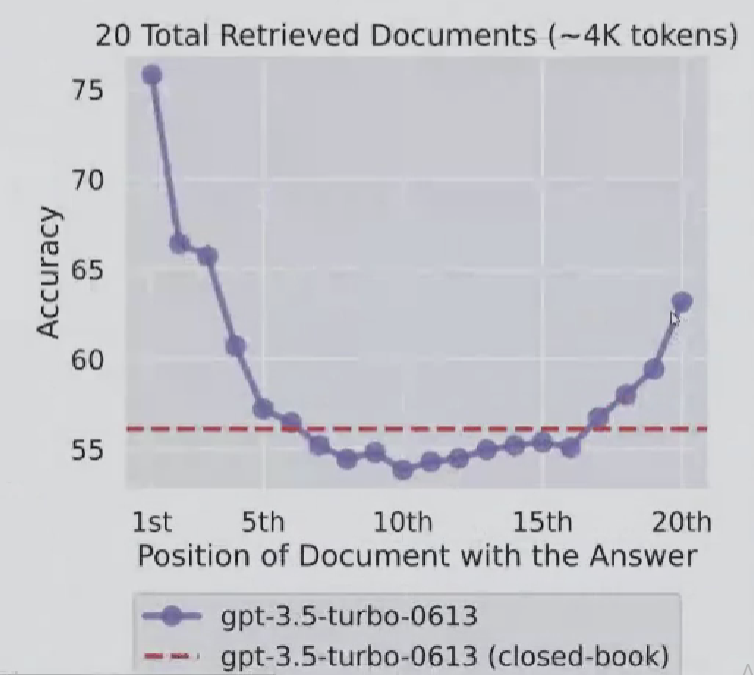

The most importand documents must be in the beginning as well as the end of the context query

In [31]:
from langchain_community.document_transformers import LongContextReorder

reordering = LongContextReorder()
reordered_docs = reordering.transform_documents(docs)
reordered_docs

[[Document(page_content='The Massachusetts Institute of Technology (MIT) is a private land-grant research university in Cambridge, Massachusetts. Established in 1861, MIT has played a significant role in the development of many areas of modern technology and science.', metadata={'source': 'mit.txt'}),
  Document(page_content='Founded in response to the increasing industrialization of the United States, MIT adopted a European polytechnic university model and stressed laboratory instruction in applied science and engineering. MIT is one of three private land-grant', metadata={'source': 'mit.txt'}),
  Document(page_content='MIT was informally called "Boston Tech".[32] The institute adopted the European polytechnic university model and emphasized laboratory instruction from an early date.[27] Despite chronic financial problems, the institute saw growth in the last two', metadata={'source': 'mit.txt'}),
  Document(page_content='entrepreneurial culture and MIT alumni have founded or co-found

#Let's integrate it!

In [98]:
from langchain_core.runnables import RunnablePassthrough, RunnableLambda, RunnableParallel

def expand_query_chain(query):
  #Reuse previously defined variables in the earlier cells
  llm_chain = QUERY_PROMPT | llm | output_parser

  output = llm_chain.invoke(query)

  return output.lines

def retrieve_unique_docs(queries: list[str]) -> list:
  #Reuse previously defined retriever in the earlier cell

  docs = [retriever.get_relevant_documents(query) for query in queries["queries"]]

  unique_contents = set()
  unique_docs = []

  for sublist in docs:
    for doc in sublist:
      if doc.page_content not in unique_contents:
        unique_contents.add(doc.page_content)
        unique_docs.append(doc)

  return list(unique_contents)

def sort_with_cross_encoder(input: dict):
  #Reuse previously defined cross encoder in earlier cell
  #Unpack chained inputs
  docs = input['unique_docs']
  query = input['query']['query']

  pairs = []
  for doc in docs:
    pairs.append([query, doc])

  scores = cross_encoder.predict(pairs)
  scored_docs = zip(scores, docs)
  sorted_docs = sorted(scored_docs, reverse=True)

  return sorted_docs

def rerank_docs(input):
  #Unpack chained inputs
  sorted_docs = input['sorted_docs']
  return [doc for _, doc in sorted_docs][0:5]

def reorder_docs(input):
  #Unpack chained inputs
  #Within context of chain, this is a list of docs as the param

  reordering = LongContextReorder()
  reordered_docs = reordering.transform_documents(input)

  return reordered_docs

# Full rerank retriever:
# 1. Perform query expansion
# 2. Retrieve documents as usual
# 3. Use crossencoder to rerank
# 4. Return reranked docs

query_expansion = RunnableParallel(
    {
        "query": RunnablePassthrough(),
        "queries": expand_query_chain
    }
)

unique_docs_retriever = RunnableParallel(
    {
        "query": RunnablePassthrough(),
        "unique_docs": retrieve_unique_docs
    }
)

crossencoder_chain = RunnableParallel(
    {
        "query": RunnablePassthrough(),
        "sorted_docs": RunnableLambda(sort_with_cross_encoder)
    }
)

rerank_and_reorder = RunnableParallel(
  {
      "query": RunnablePassthrough(),
      "context": RunnableLambda(rerank_docs) | RunnableLambda(reorder_docs)
  }
)

full_rerank_retriever = RunnableParallel(
    {
        "query": RunnablePassthrough(),
        "context": query_expansion | unique_docs_retriever | crossencoder_chain | rerank_and_reorder
    }
)

In [99]:
reranked_documents = full_rerank_retriever.invoke(query)

['The Massachusetts Institute of Technology (MIT) is a private land-grant research university in Cambridge, Massachusetts. Established in 1861, MIT has played a significant role in the development of many areas of modern technology and science.', 'entrepreneurial culture and MIT alumni have founded or co-founded many notable companies.[15][16] MIT is a member of the Association of American Universities.[17]', 'The Compton reforms "renewed confidence in the ability of the Institute to develop leadership in science as well as in engineering".[46] Unlike Ivy League schools, MIT catered more to middle-class families, and depended more on tuition than on', 'MIT was informally called "Boston Tech".[32] The institute adopted the European polytechnic university model and emphasized laboratory instruction from an early date.[27] Despite chronic financial problems, the institute saw growth in the last two', 'Founded in response to the increasing industrialization of the United States, MIT adopte

In [95]:
reranked_documents

{'query': 'What is MIT?',
 'context': {'query': {'query': {'query': {'query': 'What is MIT?',
     'queries': ['What is the Massachusetts Institute of Technology?',
      'What is the history of MIT?',
      'What are the research areas at MIT?',
      'What are the notable alumni of MIT?',
      'What is the impact of MIT on the world?']},
    'unique_docs': ['Technology and Innovation recipients, 50 MacArthur Fellows,[12] 83 Marshall Scholars,[13] 41 astronauts,[14] 16 Chief Scientists of the US Air Force, and 1 foreign head of state have been affiliated with MIT. The institute also has a strong',
     'over the vehement objections of MIT faculty, students, and alumni.[38] However, a 1917 decision by the Massachusetts Supreme Judicial Court effectively put an end to the merger scheme.[38]',
     'As of October 2023, 101 Nobel laureates,[10] 26 Turing Award winners, and 8 Fields Medalists have been affiliated with MIT as alumni, faculty members, or researchers.[11] In addition, 58 Nat

In [127]:
query = "What is the history of MIT?"

llm = GoogleGenerativeAI(model="gemini-1.0-pro")

QAPROMPT = PromptTemplate(
    template = """
    You are an AI model assistant for question-answering tasks.
    Use the following pieces of context to answer the question and provide a detailed answer based on the context.
    If you don't know the answer, just say that you don't know, won't try to make up an answer.
    Question: {query}

    Context:
    {context}

    Answer:
    """,
    input_variables=["context", "query"]
)

def extract_prompt_variables(input):
  return {
      "context": input['context']['context'],
      "query": input['query']
  }

# Normal retriever
regular_retriever = RunnableParallel({"context": retriever, "query": RunnablePassthrough()})

#Normal Retrieval Chain
QAChain = regular_retriever | QAPROMPT | llm

#ReRank Retrieval Chain
rerank_retrieval_chain = full_rerank_retriever | extract_prompt_variables | QAPROMPT | llm

In [128]:
QAChain.invoke(query)

"MIT was established in 1861 in response to the increasing industrialization of the United States. It adopted a European polytechnic university model and stressed laboratory instruction in applied science and engineering. MIT's first classes were held in the Mercantile Building in Boston in 1865."

In [129]:
rerank_retrieval_chain.invoke(query)

['The Massachusetts Institute of Technology (MIT) is a private land-grant research university in Cambridge, Massachusetts. Established in 1861, MIT has played a significant role in the development of many areas of modern technology and science.', "Two days after MIT was chartered, the first battle of the Civil War broke out. After a long delay through the war years, MIT's first classes were held in the Mercantile Building in Boston in 1865.[29] The new institute was founded as part of the", "The Rogers Plan reflected the German research university model, emphasizing an independent faculty engaged in research, as well as instruction oriented around seminars and laboratories.[27][28]\n\nEarly developments\n\nA 1905 map of MIT's Boston campus", 'MIT was informally called "Boston Tech".[32] The institute adopted the European polytechnic university model and emphasized laboratory instruction from an early date.[27] Despite chronic financial problems, the institute saw growth in the last two

"MIT was founded in 1861 in response to the increasing industrialization of the United States. It adopted a European polytechnic university model and stressed laboratory instruction in applied science and engineering. After a long delay through the war years, MIT's first classes were held in the Mercantile Building in Boston in 1865. The new institute was founded as part of the Rogers Plan, which reflected the German research university model and emphasized an independent faculty engaged in research, as well as instruction oriented around seminars and laboratories."